In [1]:
%run ./Definitions.ipynb

2019-12-25 02:34:41.005679
thunder  Wed Dec 25 02:34:41 2019
[0] GeForce GTX 1080 Ti | 41'C,   0 % |  8605 / 11178 MB | patra(8595M)
[1] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |   699 / 11178 MB | srikanth(689M)
[7] GeForce GTX 1080 Ti | 28'C,   0 % | 10936 / 11178 MB | hemelinr(10926M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

Wed Dec 25 02:34:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   41C    P2    89W / 250W |   8605MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   27C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# Converting class values to int 1 or 0
upsampled[Class] = upsampled[Class].astype(int)

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

In [9]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

## Define Model and Metrics

In [10]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
    
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [11]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [12]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [13]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True,
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./127.5-1) 
val_datagen = ImageDataGenerator(samplewise_center=True, featurewise_center=True, 
                                 featurewise_std_normalization=True, rescale= 1./127.5-1)  
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)


Found 198910 validated image filenames.
Found 33943 validated image filenames.


In [14]:
# which_model = make_model
which_model = mobilenet_model
# which_model = vgg_model
model = which_model()

learning_rate  = 0.0001 
decay = 1e-3
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [15]:
# With L2 weight regularizer
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1)
keras_model_path = funduspath_CR + 'Models/'
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

In [16]:
start = time.time()
history = model.fit_generator(train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 50s 999ms/step - loss: 0.7110 - Accuracy: 0.5781 - Precision: 0.5813 - Recall: 0.6114 - F1: 0.5888 - AUC: 0.6055 - val_loss: 0.6566 - val_Accuracy: 0.5938 - val_Precision: 0.0153 - val_Recall: 0.1333 - val_F1: 0.0261 - val_AUC: 0.3803
Epoch 2/200
50/50 [==============================] - 47s 938ms/step - loss: 0.6658 - Accuracy: 0.6206 - Precision: 0.6187 - Recall: 0.6569 - F1: 0.6319 - AUC: 0.6621 - val_loss: 0.9214 - val_Accuracy: 0.1562 - val_Precision: 0.0106 - val_Recall: 0.3000 - val_F1: 0.0206 - val_AUC: 0.6451
Epoch 3/200
50/50 [==============================] - 48s 963ms/step - loss: 0.6606 - Accuracy: 0.6325 - Precision: 0.6325 - Recall: 0.6244 - F1: 0.6198 - AUC: 0.6747 - val_loss: 2.4118 - val_Accuracy: 0.0125 - val_Precision: 0.0125 - val_Recall: 0.4000 - val_F1: 0.0242 - val_AUC: 0.4743
Epoch 4/200
50/50 [==============================] - 48s 953ms/step - loss: 0.6117 - Accuracy: 0.6737 - Precision: 0.6626 - Recall: 0.7001 - F1: 0.6

50/50 [==============================] - 51s 1s/step - loss: 0.5577 - Accuracy: 0.7138 - Precision: 0.7141 - Recall: 0.7343 - F1: 0.7195 - AUC: 0.7855 - val_loss: 2.4547 - val_Accuracy: 0.0219 - val_Precision: 0.0219 - val_Recall: 0.5000 - val_F1: 0.0417 - val_AUC: 0.5623
Epoch 30/200
50/50 [==============================] - 50s 1s/step - loss: 0.5548 - Accuracy: 0.7156 - Precision: 0.7095 - Recall: 0.7398 - F1: 0.7192 - AUC: 0.7889 - val_loss: 2.5739 - val_Accuracy: 0.0188 - val_Precision: 0.0188 - val_Recall: 0.3000 - val_F1: 0.0343 - val_AUC: 0.5204
Epoch 31/200
50/50 [==============================] - 50s 994ms/step - loss: 0.5447 - Accuracy: 0.7169 - Precision: 0.7000 - Recall: 0.7475 - F1: 0.7163 - AUC: 0.8005 - val_loss: 2.2994 - val_Accuracy: 0.0375 - val_Precision: 0.0345 - val_Recall: 0.8000 - val_F1: 0.0658 - val_AUC: 0.5662
Epoch 32/200
50/50 [==============================] - 50s 1s/step - loss: 0.5606 - Accuracy: 0.7163 - Precision: 0.7237 - Recall: 0.7413 - F1: 0.7263 - 

50/50 [==============================] - 50s 1s/step - loss: 0.5323 - Accuracy: 0.7444 - Precision: 0.7315 - Recall: 0.7740 - F1: 0.7469 - AUC: 0.8111 - val_loss: 2.4972 - val_Accuracy: 0.0469 - val_Precision: 0.0440 - val_Recall: 0.7000 - val_F1: 0.0824 - val_AUC: 0.4267
Epoch 58/200
50/50 [==============================] - 52s 1s/step - loss: 0.5476 - Accuracy: 0.7181 - Precision: 0.7024 - Recall: 0.7542 - F1: 0.7210 - AUC: 0.7964 - val_loss: 2.1727 - val_Accuracy: 0.0281 - val_Precision: 0.0252 - val_Recall: 0.7000 - val_F1: 0.0485 - val_AUC: 0.6076
Epoch 59/200
50/50 [==============================] - 52s 1s/step - loss: 0.5567 - Accuracy: 0.7094 - Precision: 0.7028 - Recall: 0.7361 - F1: 0.7136 - AUC: 0.7854 - val_loss: 2.3820 - val_Accuracy: 0.0219 - val_Precision: 0.0219 - val_Recall: 0.5000 - val_F1: 0.0417 - val_AUC: 0.5114
Epoch 60/200
50/50 [==============================] - 52s 1s/step - loss: 0.5431 - Accuracy: 0.7437 - Precision: 0.7521 - Recall: 0.7446 - F1: 0.7436 - AUC

Epoch 86/200
50/50 [==============================] - 52s 1s/step - loss: 0.5615 - Accuracy: 0.7106 - Precision: 0.7296 - Recall: 0.7282 - F1: 0.7228 - AUC: 0.7815 - val_loss: 2.0333 - val_Accuracy: 0.0188 - val_Precision: 0.0188 - val_Recall: 0.5000 - val_F1: 0.0360 - val_AUC: 0.4416
Epoch 87/200
50/50 [==============================] - 51s 1s/step - loss: 0.5674 - Accuracy: 0.7056 - Precision: 0.7154 - Recall: 0.7256 - F1: 0.7127 - AUC: 0.7737 - val_loss: 2.2216 - val_Accuracy: 0.0219 - val_Precision: 0.0219 - val_Recall: 0.5000 - val_F1: 0.0417 - val_AUC: 0.6198
Epoch 88/200
50/50 [==============================] - 52s 1s/step - loss: 0.5412 - Accuracy: 0.7331 - Precision: 0.7427 - Recall: 0.7605 - F1: 0.7448 - AUC: 0.8037 - val_loss: 2.1400 - val_Accuracy: 0.0312 - val_Precision: 0.0312 - val_Recall: 0.7000 - val_F1: 0.0592 - val_AUC: 0.4860
Epoch 89/200
50/50 [==============================] - 51s 1s/step - loss: 0.5525 - Accuracy: 0.7275 - Precision: 0.7290 - Recall: 0.7484 - F1:

50/50 [==============================] - 49s 972ms/step - loss: 0.5490 - Accuracy: 0.7237 - Precision: 0.7174 - Recall: 0.7512 - F1: 0.7277 - AUC: 0.7985 - val_loss: 2.2266 - val_Accuracy: 0.0125 - val_Precision: 0.0125 - val_Recall: 0.2000 - val_F1: 0.0232 - val_AUC: 0.5977
Epoch 115/200
50/50 [==============================] - 49s 980ms/step - loss: 0.5673 - Accuracy: 0.7025 - Precision: 0.6817 - Recall: 0.7274 - F1: 0.6968 - AUC: 0.7770 - val_loss: 2.0369 - val_Accuracy: 0.0219 - val_Precision: 0.0219 - val_Recall: 0.5000 - val_F1: 0.0417 - val_AUC: 0.2889
Epoch 116/200
50/50 [==============================] - 49s 985ms/step - loss: 0.5552 - Accuracy: 0.7100 - Precision: 0.6920 - Recall: 0.7464 - F1: 0.7095 - AUC: 0.7882 - val_loss: 2.4020 - val_Accuracy: 0.0219 - val_Precision: 0.0219 - val_Recall: 0.5000 - val_F1: 0.0417 - val_AUC: 0.6492
Epoch 117/200
50/50 [==============================] - 49s 977ms/step - loss: 0.5604 - Accuracy: 0.7081 - Precision: 0.7028 - Recall: 0.7299 - F

50/50 [==============================] - 49s 980ms/step - loss: 0.5468 - Accuracy: 0.7300 - Precision: 0.7270 - Recall: 0.7545 - F1: 0.7348 - AUC: 0.7980 - val_loss: 2.2617 - val_Accuracy: 0.0281 - val_Precision: 0.0250 - val_Recall: 0.5000 - val_F1: 0.0471 - val_AUC: 0.5709
Epoch 143/200
50/50 [==============================] - 50s 991ms/step - loss: 0.5499 - Accuracy: 0.7300 - Precision: 0.7291 - Recall: 0.7589 - F1: 0.7362 - AUC: 0.7942 - val_loss: 2.2018 - val_Accuracy: 0.0250 - val_Precision: 0.0219 - val_Recall: 0.5000 - val_F1: 0.0414 - val_AUC: 0.6524
Epoch 144/200
50/50 [==============================] - 50s 998ms/step - loss: 0.5509 - Accuracy: 0.7200 - Precision: 0.7304 - Recall: 0.7391 - F1: 0.7284 - AUC: 0.7907 - val_loss: 2.2727 - val_Accuracy: 0.0344 - val_Precision: 0.0282 - val_Recall: 0.8000 - val_F1: 0.0544 - val_AUC: 0.5613
Epoch 145/200
50/50 [==============================] - 50s 991ms/step - loss: 0.5372 - Accuracy: 0.7319 - Precision: 0.7149 - Recall: 0.7676 - F

50/50 [==============================] - 48s 970ms/step - loss: 0.5589 - Accuracy: 0.7150 - Precision: 0.7070 - Recall: 0.7350 - F1: 0.7143 - AUC: 0.7867 - val_loss: 2.1982 - val_Accuracy: 0.0250 - val_Precision: 0.0219 - val_Recall: 0.5000 - val_F1: 0.0414 - val_AUC: 0.5091
Epoch 171/200
50/50 [==============================] - 49s 973ms/step - loss: 0.5458 - Accuracy: 0.7219 - Precision: 0.6981 - Recall: 0.7526 - F1: 0.7183 - AUC: 0.7997 - val_loss: 2.2446 - val_Accuracy: 0.0250 - val_Precision: 0.0250 - val_Recall: 0.6000 - val_F1: 0.0474 - val_AUC: 0.4892
Epoch 172/200
50/50 [==============================] - 50s 993ms/step - loss: 0.5460 - Accuracy: 0.7219 - Precision: 0.7182 - Recall: 0.7534 - F1: 0.7250 - AUC: 0.7983 - val_loss: 2.2902 - val_Accuracy: 0.0219 - val_Precision: 0.0219 - val_Recall: 0.6000 - val_F1: 0.0421 - val_AUC: 0.6228
Epoch 173/200
50/50 [==============================] - 50s 994ms/step - loss: 0.5343 - Accuracy: 0.7369 - Precision: 0.7545 - Recall: 0.7541 - F

50/50 [==============================] - 48s 963ms/step - loss: 0.5589 - Accuracy: 0.7075 - Precision: 0.6955 - Recall: 0.7385 - F1: 0.7106 - AUC: 0.7819 - val_loss: 2.1000 - val_Accuracy: 0.0406 - val_Precision: 0.0377 - val_Recall: 0.6000 - val_F1: 0.0703 - val_AUC: 0.4658
Epoch 199/200
50/50 [==============================] - 48s 961ms/step - loss: 0.5424 - Accuracy: 0.7375 - Precision: 0.7234 - Recall: 0.7684 - F1: 0.7373 - AUC: 0.8051 - val_loss: 2.3600 - val_Accuracy: 0.0375 - val_Precision: 0.0347 - val_Recall: 0.6000 - val_F1: 0.0647 - val_AUC: 0.5924
Epoch 200/200
50/50 [==============================] - 48s 959ms/step - loss: 0.5428 - Accuracy: 0.7163 - Precision: 0.7125 - Recall: 0.7424 - F1: 0.7197 - AUC: 0.7994 - val_loss: 2.1854 - val_Accuracy: 0.0437 - val_Precision: 0.0377 - val_Recall: 0.7000 - val_F1: 0.0704 - val_AUC: 0.5641


In [17]:
print("Time taken:",end-start)

Time taken: 9977.030344963074


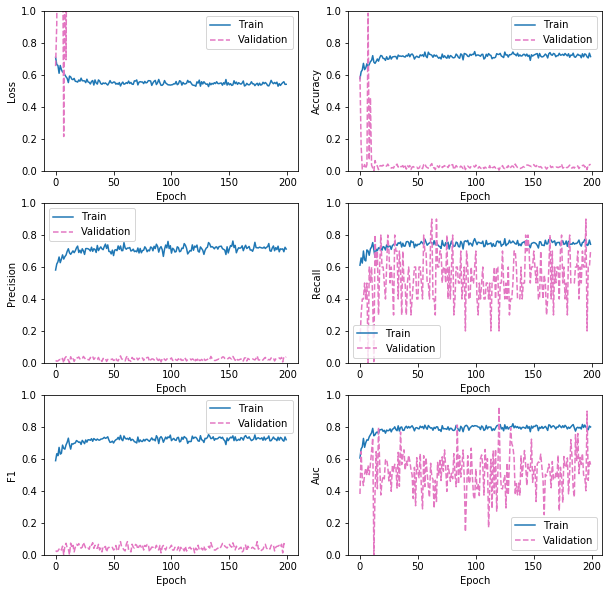

In [18]:
plt.figure(figsize=(10,10))
plot_metrics(history)

## Evaluation

In [19]:
results_tr = model.evaluate(train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 15s 147ms/step


In [20]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))


NAME :	TRAIN :	VALIDATION 
loss : 1.179 :   2.230
Accuracy : 0.499 :   0.021
Precision : 0.500 :   0.020
Recall : 0.992 :   0.450
F1 : 0.660 :   0.037
AUC : 0.514 :   0.508


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [21]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(5974.8744695186615, 123.00362706184387)

In [22]:
# TRUE LABELS

train_labels = upsampled[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


In [23]:
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_tr_78_fw_decay_e-3.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_vl_78_fw_decay_e-3.npy', pred_vl)

### ROC Curve

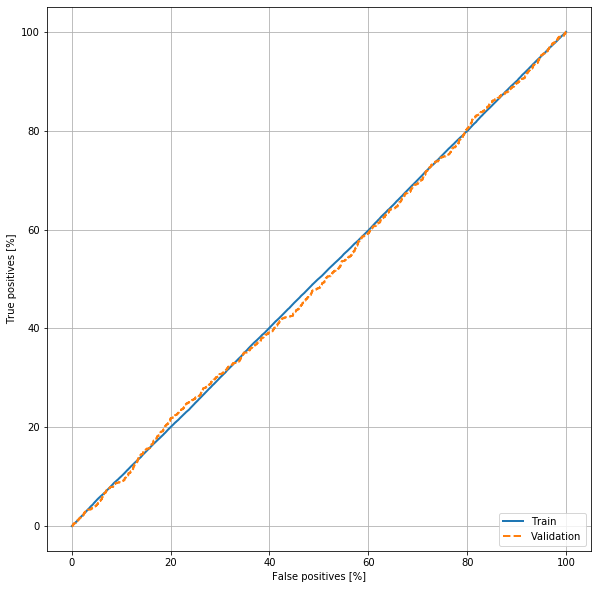

In [24]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 862 
FP: 98593 
FN: 830 
TP: 98625
Healthy Patients - correctly identified (True Negatives):  862 0.008667236438590317
Healthy Patients - predicted to have glaucoma (False Positives):  98593 0.9913327635614096
Glaucoma Patients - predicted healthy (False Negatives):  830 0.008345482881705293
Glaucoma Patients - correctly identified (True Positives):  98625 0.9916545171182947

Total Glaucoma patients:  99455 1.0
Total Healthy patients:  99455 1.0


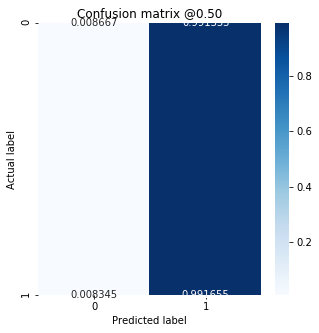

In [25]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 79 
FP: 33055 
FN: 4 
TP: 805
Healthy Patients - correctly identified (True Negatives):  79 0.0023842578620148487
Healthy Patients - predicted to have glaucoma (False Positives):  33055 0.9976157421379852
Glaucoma Patients - predicted healthy (False Negatives):  4 0.004944375772558714
Glaucoma Patients - correctly identified (True Positives):  805 0.9950556242274413

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


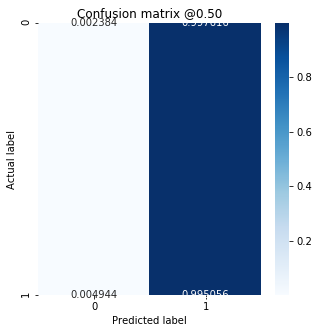

In [26]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 